In [12]:
import geopandas as gpd
import pandas as pd

In [17]:
SHAPEFILE = r'F:\Programming\Julya\russia_heatmap\RF\admin_4.shp'
# Read shapefile using Geopandas
geo_df = gpd.read_file(SHAPEFILE)[["name_ru", "ref", "geometry"]]
geo_df.head(3)

,name_ru,ref,geometry
0,Сумска,NaN,"POLYGON ((35.39847 50.90907, 35.39812 50.90910..."
1,Камчатский край,RU-KAM,"MULTIPOLYGON (((168.44560 54.51135, 168.44581 ..."
2,Мурманская область,RU-MUR,"POLYGON ((42.50570 66.99024, 42.31571 66.86190..."


<Axes: >

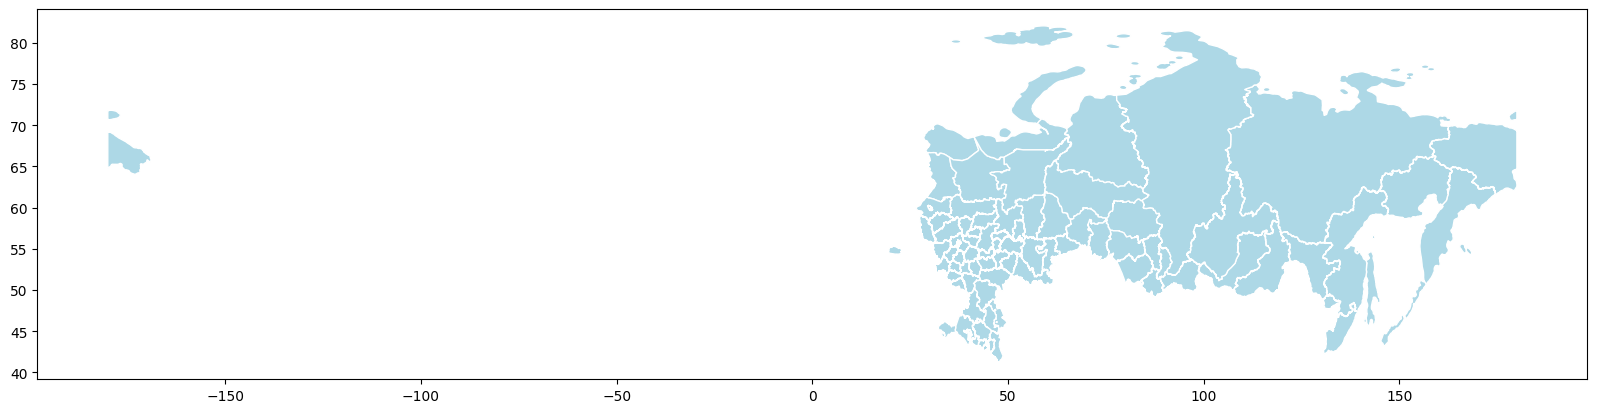

In [10]:
# Rename columns.
geo_df.plot(figsize=(20, 20), edgecolor='white', linewidth=1, color='lightblue')

In [16]:
colormap_data = pd.read_csv(r'F:\Programming\Julya\russia_heatmap\RF\colormap.csv')
colormap_data.head(3)

,Названия строк,Количество по полю убыток,Сумма по полю З_ОТ,Сумма по полю У_ОТ,Процент
0,Карачаево-Черкесская Республика,10,1747206,1363339,"21,97%"
1,Кабардино - Балкарская Республика,11,2257260,1672609,"25,90%"
2,Республика Адыгея,9,1428702,1055555,"26,12%"


In [23]:
[n for n in list(geo_df['name_ru']) if n.startswith("Ад")]

['Адыгея']

In [21]:
len(list(colormap_data['Названия строк']))

83